# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = '../../data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [4]:
print("Train Feature Size: {}".format(train_X.shape))
print("Val Feature Size: {}".format(val_X.shape))
print("Test Feature Size: {}".format(test_X.shape))

Train Feature Size: (222, 10)
Val Feature Size: (223, 10)
Test Feature Size: (446, 10)


# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [5]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

"""
Your Code Here (Hint : 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同)
因為梯度提升樹分類器出來的葉編碼, 每個類別都會有一組(二元分類有兩組, 三類別有三組, 以此類推)，所以[:, :, 0]指的是只取第一個類別的葉編碼
"""
rf.fit(train_X, train_Y)
print("Leaf Node of train_X: \n{}".format(rf.apply(train_X)))
print("\nSize: {}".format(rf.apply(train_X).shape))
onehot.fit(rf.apply(train_X))
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)
print("\nOne-hot after random forest: {}".format(onehot.transform(rf.apply(val_X))))

Leaf Node of train_X: 
[[12  9  8 ... 11  9 11]
 [11  9  8 ... 12 10 11]
 [ 4  2  5 ...  2  2  7]
 ...
 [ 4  2  5 ...  2  2  7]
 [11  9  8 ... 11  9 11]
 [ 9 10 12 ...  4  9 14]]

Size: (222, 20)

One-hot after random forest:   (0, 1)	1.0
  (0, 7)	1.0
  (0, 15)	1.0
  (0, 21)	1.0
  (0, 28)	1.0
  (0, 36)	1.0
  (0, 44)	1.0
  (0, 56)	1.0
  (0, 58)	1.0
  (0, 68)	1.0
  (0, 74)	1.0
  (0, 83)	1.0
  (0, 91)	1.0
  (0, 95)	1.0
  (0, 108)	1.0
  (0, 115)	1.0
  (0, 122)	1.0
  (0, 125)	1.0
  (0, 132)	1.0
  (0, 138)	1.0
  (1, 0)	1.0
  (1, 8)	1.0
  (1, 13)	1.0
  (1, 23)	1.0
  (1, 30)	1.0
  :	:
  (221, 112)	1.0
  (221, 122)	1.0
  (221, 128)	1.0
  (221, 133)	1.0
  (221, 141)	1.0
  (222, 1)	1.0
  (222, 9)	1.0
  (222, 15)	1.0
  (222, 23)	1.0
  (222, 31)	1.0
  (222, 39)	1.0
  (222, 43)	1.0
  (222, 54)	1.0
  (222, 60)	1.0
  (222, 68)	1.0
  (222, 76)	1.0
  (222, 84)	1.0
  (222, 90)	1.0
  (222, 99)	1.0
  (222, 108)	1.0
  (222, 112)	1.0
  (222, 122)	1.0
  (222, 129)	1.0
  (222, 132)	1.0
  (222, 141)	1.0


In [6]:
for i in range(5):
    print(rf.apply(train_X)[i])

[12  9  8 11 11 13 10  6  8 13 13 11  9 11  7  7 12 11  9 11]
[11  9  8 12 12 14 11  7  9 13 13 10  7 11  6  4  4 12 10 11]
[ 4  2  5  5  4  3  7 13  2  4  4  6  5  2  4 11  9  2  2  7]
[ 3  4  3  8  8 10  3  4  4  3  6  3  4  8  6  4  2  8  2  3]
[12  9  8 12 12 14 11  6  9 13 13 10  7 11  6  4  5 12 10 11]


In [7]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
"""
Your Code Here 
"""
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)
# 將隨機森林結果輸出
"""
Your Code Here 
"""
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

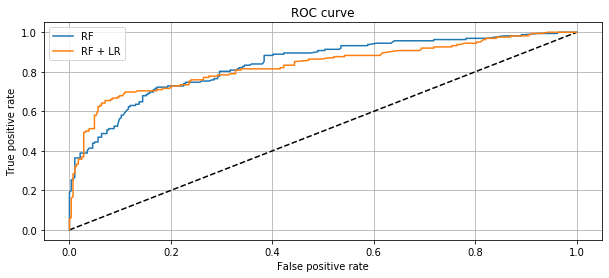

In [8]:
import matplotlib.pyplot as plt
# 將結果繪圖
"""
Your Code Here 
"""
plt.figure(figsize=(10, 4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

## Metric: Precision and Recall
- Precision => 預測為 True 的有多少是對的
- Recall => 有多少的 True 值被預測成功

## Conclusion
- 如果覺得找到 True 值很重要的話（寧可猜錯，不可漏掉）：Precision 低、Recall 高
- 如果覺得漏掉 True 值成本不會很高的話（寧可漏掉，也不要亂猜）：Precision 高、Recall 低

## Example
舉例來說，如果現在要預測的是炸彈會不會爆炸：
- 以 Precision = 0.2 來說，表示你猜了 10 個真的炸彈中，只有兩個是猜對的。
- 以 Recall = 0.2 來說，表示在全部 10 個真的炸彈中，你只猜中了其中的兩個。因為漏掉爆炸的成本很高，寧可猜會爆炸，也不希望漏掉。

所以會採用 Precision 低、Recall 高